# [How to apply LSTM using PyTorch](https://cnvrg.io/pytorch-lstm/) - Practical Implementation in PyTorch


In [2]:
import sys
import os
from os import path
import importlib

import numpy as np
np.set_printoptions(formatter={'float_kind':"{:-.3e}".format})
np.random.seed(0)

import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5, 4)

import torch
torch.manual_seed(0)

import torch.nn as nn
from torch.autograd import Variable

SRC_DIR = path.join(os.path.abspath(""), '../')
sys.path.append(SRC_DIR)

import core as co
from core import _
import hist_data as hd

In [3]:
hd.set_hist_data(data_count=None)

In [72]:
import nn_tools.data_sequencer as ds
importlib.reload(ds)

<module 'nn_tools.data_sequencer' from 'c:\\users\\stefa\\documents\\workspaces\\szx81\\szx81\\nn_tools\\data_sequencer.py'>

## Noisy Sinus Training&Testing data

In [73]:
NUM_LAYERS = 3
end_day = 2
context_len = 10
future_len = 5


cs = ds.ContextSequencer(
    ds.SinusDataSource, end_day=end_day, seq_len=context_len, 
    future_len=future_len)

X_train, y_train = cs.get_training(count=1000, verbose=True)
print()
print(f'last X_train:\n{X_train[-1]}')
print(f'last y_train:\n{y_train[-1]}')

begin index: 2880, end index: 3895, count:1000

last X_train:
[-2.260e-01 -2.783e-01 -2.639e-01 -1.112e+00 -1.030e+00 -3.110e-01
 -8.929e-01 -9.897e-01 -1.003e+00 -1.331e+00]
last y_train:
-1.3439325844413763


end=3895 data len=25, seq_len=10, count=10 future_len=5
x:
[[3869 3870 3871 3872 3873 3874 3875 3876 3877 3878]
 [3870 3871 3872 3873 3874 3875 3876 3877 3878 3879]
 [3871 3872 3873 3874 3875 3876 3877 3878 3879 3880]
 [3872 3873 3874 3875 3876 3877 3878 3879 3880 3881]
 [3873 3874 3875 3876 3877 3878 3879 3880 3881 3882]
 [3874 3875 3876 3877 3878 3879 3880 3881 3882 3883]
 [3875 3876 3877 3878 3879 3880 3881 3882 3883 3884]
 [3876 3877 3878 3879 3880 3881 3882 3883 3884 3885]
 [3877 3878 3879 3880 3881 3882 3883 3884 3885 3886]
 [3878 3879 3880 3881 3882 3883 3884 3885 3886 3887]]
y:
[3883 3884 3885 3886 3887 3888 3889 3890 3891 3892]


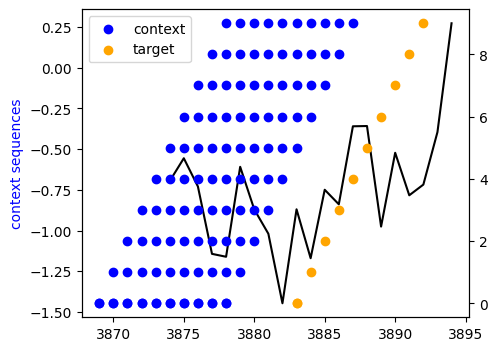

In [67]:
cs.plot()

## Forex Training&Testing data

In [74]:
NUM_LAYERS = 3
end_day = 2
context_len = 10
future_len = 5


cs = ds.ContextSequencer(
    ds.ForexDataSource, end_day=end_day, seq_len=context_len, 
    future_len=future_len)

X_train, y_train = cs.get_training(count=1000, verbose=True)
print()
print(f'last X_train:\n{X_train[-1]}')
print(f'last y_train:\n{y_train[-1]}')

begin index: 2880, end index: 3895, count:1000

last X_train:
[-6.368e-03 -6.387e-03 -6.396e-03 -6.290e-03 -6.305e-03 -6.209e-03
 -6.368e-03 -6.417e-03 -6.446e-03 -6.495e-03]
last y_train:
-0.006445748263888551


end=3895 data len=25, seq_len=10, count=10 future_len=5
x:
[[3869 3870 3871 3872 3873 3874 3875 3876 3877 3878]
 [3870 3871 3872 3873 3874 3875 3876 3877 3878 3879]
 [3871 3872 3873 3874 3875 3876 3877 3878 3879 3880]
 [3872 3873 3874 3875 3876 3877 3878 3879 3880 3881]
 [3873 3874 3875 3876 3877 3878 3879 3880 3881 3882]
 [3874 3875 3876 3877 3878 3879 3880 3881 3882 3883]
 [3875 3876 3877 3878 3879 3880 3881 3882 3883 3884]
 [3876 3877 3878 3879 3880 3881 3882 3883 3884 3885]
 [3877 3878 3879 3880 3881 3882 3883 3884 3885 3886]
 [3878 3879 3880 3881 3882 3883 3884 3885 3886 3887]]
y:
[3883 3884 3885 3886 3887 3888 3889 3890 3891 3892]


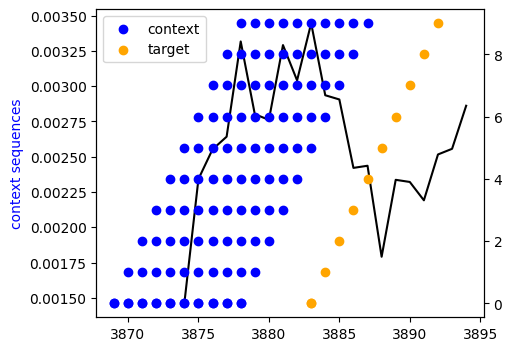

In [75]:
cs.plot()

In [76]:
def data_preprocessing(X, y):
    X = StandardScaler().fit_transform(X)
    X = Variable(torch.Tensor(X))
    X = torch.reshape(X, (X.shape[0], 1, X.shape[1]))

    y = y.reshape(-1, 1)
    y = MinMaxScaler().fit_transform(y)
    y = Variable(torch.Tensor(y))

    # X = torch.tensor(X[:, :, None], dtype=torch.float32)
    # y = torch.tensor(y[:, None], dtype=torch.float32)

    return X, y

def nn_trening_result(model, X, y, offset=0, label='', 
                      color='blue', alpha=1, verbose=None):
    X, y = data_preprocessing(X, y)
    
    (mm := MinMaxScaler()).fit_transform(y) # 'Close' column
    y = mm.transform(y) #old transformers
    y = Variable(torch.Tensor(y))    #reshaping the dataset

    y_np = y.data.numpy()
    y_np = np.transpose(mm.inverse_transform(y_np))

    nn_answer = model(X)#forward pass

    if verbose is not None:
        print(f'''
              {verbose}
formatted feature data (length is {len(X)}): 
    {X[:1]}

NN question[:1] (converted from formatted feature data, length is {len(X)}):
    {X[:1]}
NN answer[:5] (length is {len(nn_answer)}): 
    {nn_answer[:1]}
              ''')

    data_predict = nn_answer.data.numpy() #numpy conversion
    data_predict = mm.inverse_transform(data_predict) #reverse transformation
    time = np.array([_ for _ in range(offset, offset + len(X))])

    data_predict = np.transpose(data_predict)
    for i in range(len(data_predict)):
        diff_0 = y_np[i][1] - data_predict[i][0]
        y_np[i] = y_np[i] - diff_0

        plt.plot((time - 1), y_np[i], label=label + f'- Actual Data', color='black', 
                 alpha=0.2, linewidth=5) #actual plot
        plt.plot(time, data_predict[i], label=label + f'- Predicted Data', 
                 color=color, alpha=alpha) #predicted plot
        plt.legend()
        plt.show() 

In [77]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(Model, self).__init__()

        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.model = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size,
            num_layers=num_layers, 
            batch_first=True)
        
        self.fc =  nn.Linear(hidden_size, output_size)

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        out, (h_n, c_n) = self.model(x, (h_0.detach(), c_0.detach()))
        out = self.fc(out[:, -1, :])  # Selecting the last output

        return out

In [78]:
num_epochs = 1000
accuracy = 1e-5
learning_rate = 0.001

input_size = 10
hidden_size = 100
output_size = 1
num_layers = NUM_LAYERS

In [79]:
X_train_t, y_train_t = data_preprocessing(X_train, y_train)

model = Model(input_size, hidden_size, num_layers, output_size)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

In [80]:
loss0 = None
for epoch in range(num_epochs):
    outputs = model(X_train_t)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_t)  
    loss.backward()
    if loss0 is None:
        loss0 = loss.item()
    if loss.item() / loss0 < accuracy:
        break
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.1e}')

Epoch [10/1000], Loss: 2.4e-01
Epoch [20/1000], Loss: 1.2e-01
Epoch [30/1000], Loss: 2.1e-02
Epoch [40/1000], Loss: 3.6e-03
Epoch [50/1000], Loss: 4.8e-03
Epoch [60/1000], Loss: 3.4e-03
Epoch [70/1000], Loss: 2.1e-03
Epoch [80/1000], Loss: 1.8e-03
Epoch [90/1000], Loss: 1.8e-03
Epoch [100/1000], Loss: 1.8e-03
Epoch [110/1000], Loss: 1.8e-03
Epoch [120/1000], Loss: 1.7e-03
Epoch [130/1000], Loss: 1.7e-03
Epoch [140/1000], Loss: 1.7e-03
Epoch [150/1000], Loss: 1.7e-03
Epoch [160/1000], Loss: 1.7e-03
Epoch [170/1000], Loss: 1.7e-03
Epoch [180/1000], Loss: 1.6e-03
Epoch [190/1000], Loss: 1.6e-03
Epoch [200/1000], Loss: 1.6e-03
Epoch [210/1000], Loss: 1.6e-03
Epoch [220/1000], Loss: 1.6e-03
Epoch [230/1000], Loss: 1.6e-03
Epoch [240/1000], Loss: 1.6e-03
Epoch [250/1000], Loss: 1.6e-03
Epoch [260/1000], Loss: 1.6e-03
Epoch [270/1000], Loss: 1.6e-03
Epoch [280/1000], Loss: 1.6e-03
Epoch [290/1000], Loss: 1.6e-03
Epoch [300/1000], Loss: 1.6e-03
Epoch [310/1000], Loss: 1.6e-03
Epoch [320/1000],

In [92]:
X_test, y_test = cs.get_testing(
    context_count= NUM_LAYERS * context_len, dist_count=50, test_count=25, 
    verbose=True)
print(len(y_test))

test count: 25, begin index: 2900, end index: 2955
55


In [106]:
def nn_trening_result(model, X, y, offset=0, label='', 
                      color='blue', alpha=1, verbose=None):
    X, y = data_preprocessing(X, y)
    
    (mm := MinMaxScaler()).fit_transform(y) # 'Close' column
    y = mm.transform(y) #old transformers
    y = Variable(torch.Tensor(y))    #reshaping the dataset

    y_np = y.data.numpy()
    y_np = mm.inverse_transform(y_np)
    y_np = np.transpose(y_np)

    nn_answer = model(X)#forward pass

    if verbose is not None:
        print(f'''
              {verbose}
formatted feature data (length is {len(X)}): 
    {X[:1]}

NN question[:1] (converted from formatted feature data, length is {len(X)}):
    {X[:1]}
NN answer[:5] (length is {len(nn_answer)}): 
    {nn_answer[:1]}
              ''')

    data_predict = nn_answer.data.numpy() #numpy conversion
    data_predict = mm.inverse_transform(data_predict) #reverse transformation
    time = np.array([_ for _ in range(offset, offset + len(X))])
    
    return X.data.numpy(), y, data_predict, time


In [107]:
X, y, data_predict, time = nn_trening_result(model, X_test, y_test,
        offset=0, label='testing', color='blue', alpha=0.3)

In [118]:
cs.future_len

5

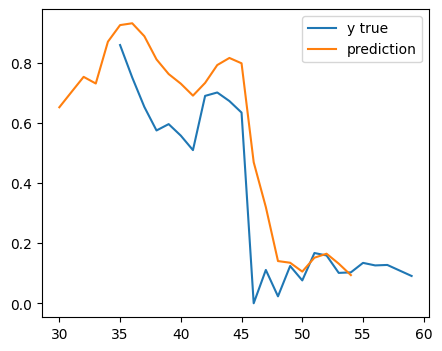

In [122]:
x = np.array([i for i in range(len(y))])
plt.plot((x + 5)[30:], y[30:], label='y true')
plt.plot(x[30:], data_predict[30:], label='prediction')
plt.legend()
plt.show()

In [79]:
print(model)

Model(
  (model): LSTM(10, 100, num_layers=3, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
)


begin index: 3030, end index: 3950, count:30

              
formatted feature data (length is 30): 
    tensor([[[-2.0788, -2.0915, -2.0473, -2.8988, -2.1179, -2.0020, -2.2183,
          -1.7760, -1.2870, -1.6204]]])

NN question[:1] (converted from formatted feature data, length is 30):
    tensor([[[-2.0788, -2.0915, -2.0473, -2.8988, -2.1179, -2.0020, -2.2183,
          -1.7760, -1.2870, -1.6204]]])
NN answer[:5] (length is 30): 
    tensor([[-0.0967]], grad_fn=<SliceBackward0>)
              


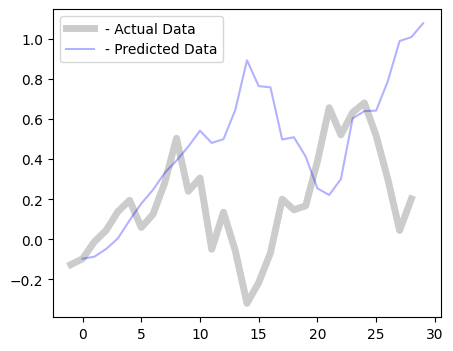

In [86]:
X, y = cs.get_testing(
    context_count=NUM_LAYERS * context_len, count=150, verbose=True)
nn_trening_result(model, X, y,
offset=0, label='', color='blue', alpha=0.3, verbose='')

In [84]:
len(y)

30